![ScreenShot](Resources/Screenshots/loading_screen.png)

# Project 4 - Advanced Lane Finding Project

### _Expanding on "Project 1 - Finding Lane Lines"_

#### Please refer to this repository's README.md for a detailed explanation of the project: 
https://github.com/nhiddink/CarND_P4_Advanced_Lane_Finding/blob/master/README.md

### Imports

In [1]:
# http://www.numpy.org/
import numpy as np

# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
import cv2

# http://matplotlib.org/
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

# https://docs.python.org/2/library/glob.html
import glob

# https://docs.python.org/2/library/os.html
import os

### I. Camera Calibration
#### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [ ]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('resources/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### II. Distortion Correction

#### Apply a distortion correction to raw images.

In [3]:
#Display list of test images for reference:
images = os.listdir("resources/test_images/")
images

['solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'test1.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            point = np.mean(line, axis=0)
            y = point[1]
            x = point[0]
            if slope < 0: 
                intercept = y - slope*x
                yLeft = intercept
                yRight = slope * 960 + intercept
                cv2.line(img, (0, int(yLeft)), (960, int(yRight)), color, thickness)
            if slope > 0:
                intercept = y - slope*x
                yLeft = intercept
                yRight = slope * 960 + intercept
                cv2.line(img, (0, int(yLeft)), (960, int(yRight)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
#Function to run math functions/algorithms in one place. See last code cell in project for details.
def main(img):
    
    #Read the image passed to main:
    image = mpimg.imread(img)
    
    #Convert to grayscale, perform gaussian blur and canny edge detection:
    gray = grayscale(image)
    gauss = gaussian_blur(gray, 5)
    can = canny(gauss, 50, 150)
    
    #Create a region of interest mask to eliminate extraneous edges:
    shape = image.shape
    vertices = np.array([[(0,shape[0]),(410, 340),(480, 310), (shape[1],shape[0])]], dtype=np.int32)
    region = region_of_interest(can, vertices)
    
    #Perform a Hough transform and draw lines onto original image. See draw_lines function below for details.
    rho = 2
    theta = 1/180
    threshold = 50
    min_line_length = 10
    max_line_gap = 20
    hough = hough_lines(region, rho, theta, threshold, min_line_length, max_line_gap)
    vertices2 = np.array([[(0,shape[0]),(410, 340),(480, 310), (shape[1],shape[0])]], dtype=np.int32)
    
    #Create a second region mask to crop extrapolating lines and format line weight:
    region2 = region_of_interest(hough, vertices2)
    weight = weighted_img(region2, image, α=0.8, β=1., λ=0.)
    
    #Display plot:
    plt.imshow(weight);

Image: solidWhiteRight.jpg


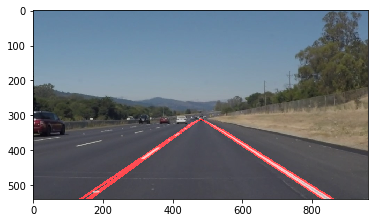

In [9]:
print('Image: ' + images[0])
main('resources/test_images/' + images[0]);

### III. Color & Gradient Thresholds
Use color transforms, gradients, etc., to create a thresholded binary image.

### IV. Perspective Transform
Apply a perspective transform to rectify binary image ("birds-eye view").

### V. Detecting Lane Lines
Detect lane pixels and fit to find the lane boundary.

### VI. Determining Lane Curvature & Warping to Original Image

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

### VII. Output
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Classes & Helper Methods

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

### Lane Detection

In [ ]:
#I first take a histogram along all the columns in the lower half of the image like this:

#img = INSERT_thresholded and warped image here!
histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [ ]:
#Radius of curvature

import numpy as np
# Generate some fake data to represent lane-line pixels
yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
leftx = np.array([200 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                              for idx, elem in enumerate(yvals)])
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = np.array([900 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                                for idx, elem in enumerate(yvals)])
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(yvals, leftx, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fit = np.polyfit(yvals, rightx, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

# Plot up the fake data
plt.plot(leftx, yvals, 'o', color='red')
plt.plot(rightx, yvals, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.plot(right_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(yvals)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(yvals*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m

In [ ]:
http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC